In [83]:
# Import Module

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# 데이터 불러오기

In [84]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

# 데이터 전처리

In [85]:
train_img = train.iloc[:,3:].to_numpy().reshape(-1,28,28,1)
train_digit = train['digit']
train_letter = train['letter']
test_img = test.iloc[:,2:].to_numpy().reshape(-1,28,28,1)
test_letter = test['letter']

In [86]:
train_img_norm = train_img / 255.0
test_img_norm = test_img / 255.0

In [87]:
features = train_img_norm
labels = train_digit.to_numpy()

X_test = test_img_norm

In [88]:
from sklearn.model_selection import train_test_split

validation_split = 0.2

X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size = validation_split, random_state = 1004)

# 필요한 함수 만들기

- createFolder : model을 저장하기 위해 폴더 만들기
- plot_curve : loss, accuracy 그래프 그리기
- create_cnn : cnn을 초기화하는 함수
- train_model_v1, train_model_v2 : train을 위한 함수

In [89]:
def createFolder(directory):
    
    import os
    
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except:
        print("Error: Falied creating directory" + directory)

In [90]:
def plot_curve(epochs, hist, list_of_metrics):
    
    fig, ax = plt.subplots(1,2,figsize = (12, 8))
    
    for i in range(len(ax)):
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Value')
        
        for n in range(len(list_of_metrics)):
            if i == 0:
                y = hist[list_of_metrics[n]]
                ax[i].plot(epochs, y)
                ax[i].set_title('Loss')
                if n == 1:
                    break
            else:
                if n >= 2:
                    y = hist[list_of_metrics[n]]
                    ax[i].plot(epochs, y)
                    ax[i].set_title('Accuracy')
                    
    plt.show()

In [91]:
def create_cnn(learning_rate):
    
    # Remove the previous model.
    model = None
    
    # Input layer
    img_input = layers.Input(shape = (28,28,1))
    
    # CNN
    # Identity mapping shortcut을 위한 conv_1 layer
    conv_1 = layers.Conv2D(128, kernel_size = 3, padding = 'same', activation = 'relu')(img_input) 
    
    conv_2_1 = layers.Conv2D(128, kernel_size = 3, padding = 'same', activation = 'relu')(conv_1)
    conv_2_1 = layers.Conv2D(128, kernel_size = 3, padding = 'same')(conv_2_1)
    
    # ShortCut connection
    add_2_1 = layers.add([conv_1, conv_2_1])
    out_2_1 = layers.Activation('relu')(add_2_1)
    
    conv_2_2 = layers.Conv2D(128, kernel_size = 3, padding = 'same', activation = 'relu')(out_2_1)
    conv_2_2 = layers.Conv2D(128, kernel_size = 3, padding = 'same')(conv_2_2)
    
    # ShortCut connection
    add_2_2 = layers.add([out_2_1, conv_2_2])
    out_2_2 = layers.Activation('relu')(add_2_1)
    
    pool_2 = layers.MaxPool2D((2,2), strides = 2)(out_2_2)
    
    conv_3_0 = layers.Conv2D(256, kernel_size = 1, strides = 1)(pool_2)
    
    conv_3_1 = layers.Conv2D(256, kernel_size = 3, padding = 'same', activation = 'relu')(conv_3_0)
    conv_3_1 = layers.Conv2D(256, kernel_size = 3, padding = 'same')(conv_3_1)
    
    # ShortCut connection
    add_3_1 = layers.add([conv_3_0, conv_3_1])
    out_3_1 = layers.Activation('relu')(add_3_1)
    
    conv_3_2 = layers.Conv2D(256, kernel_size = 3, padding = 'same', activation = 'relu')(out_3_1)
    conv_3_2 = layers.Conv2D(256, kernel_size = 3, padding = 'same')(conv_3_2)
    
    # ShortCut connection
    add_3_2 = layers.add([out_3_1, conv_3_2])
    out_3_2 = layers.Activation('relu')(add_3_2)
    
    pool_3 = layers.MaxPool2D((2,2), strides = 2)(out_3_2)
    
    conv_4_0 = layers.Conv2D(256, kernel_size = 1, strides = 1)(pool_3)
    
    conv_4_1 = layers.Conv2D(256, kernel_size = 3, padding = 'same', activation = 'relu')(conv_4_0)
    conv_4_1 = layers.Conv2D(256, kernel_size = 3, padding = 'same')(conv_4_1)
    
    # ShortCut connection
    add_4_1 = layers.add([conv_4_0, conv_4_1])
    out_4_1 = layers.Activation('relu')(add_4_1)
    
    pool_4 = layers.MaxPool2D((2,2), strides = 2)(out_4_1)
    
    # FC layers
    img_features = layers.Flatten()(pool_4)
    img_features = layers.Dense(512, activation = 'relu')(img_features)
    img_features = layers.Dropout(rate = 0.5)(img_features)
    img_features = layers.Dense(512, activation = 'relu')(img_features)
    img_features = layers.Dropout(rate = 0.5)(img_features)
    
    # Output layer
    digit_pred = layers.Dense(10, activation = 'softmax')(img_features)
    
    model = keras.Model(inputs = img_input, outputs = digit_pred)
    
    model.compile(optimizer = tf.keras.optimizers.Adam(lr = learning_rate),
                 loss = 'sparse_categorical_crossentropy',
                 metrics = ['accuracy'])
                    
    return model

In [92]:
def train_model_v1(model, X_train, y_train, X_val, y_val, epochs, batch_size = None, validation_split = 0.1):
    
    callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 10, restore_best_weights = True)
    
    history = model.fit(x = X_train, y = y_train, epochs = epochs, batch_size = batch_size,
                       shuffle = True, validation_data = (X_val, y_val), callbacks = (callback))
    
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    
    return epochs, hist

def train_model_v2(model, X_train, y_train, X_val, y_val, epochs, batch_size = None, validation_split = 0.1):
    
    callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)
    
    history = model.fit(x = X_train, y = y_train, epochs = epochs, batch_size = batch_size,
                       shuffle = True, validation_data = (X_val, y_val), callbacks = (callback))
    
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    
    return epochs, hist

#  모델 Training

- 저는 10개의 모델을 학습한 후에 10개의 출력물을 더하는 방식으로 앙상블을 진행했습니다.
- 훈련은 data를 train_set, val_set 으로 나누어서 먼저 train_set을 학습 시켰으며 train_set으로 학습이 끝난후에는 val_set의 데이터도 학습용으로 사용하기 위해서 val_set을 이용한 학습을 진행하였습니다. (데이터의 양이 적어 val_set도 학습에 포함시켰습니다.)

In [93]:
model_list = []

for i in range(10):
    model = create_cnn(learning_rate = 0.0001)
    model_list.append(model)

***************Trainig_my_model_0*****************
Epoch 1/200
1638/1638 [==============================] - 8s 5ms/step - loss: 2.3083 - accuracy: 0.0971 - val_loss: 2.3008 - val_accuracy: 0.1317
Epoch 2/200
1638/1638 [==============================] - 8s 5ms/step - loss: 2.2825 - accuracy: 0.1270 - val_loss: 1.9849 - val_accuracy: 0.2854
Epoch 3/200
1638/1638 [==============================] - 8s 5ms/step - loss: 1.8409 - accuracy: 0.3620 - val_loss: 1.5649 - val_accuracy: 0.4537
Epoch 4/200
1638/1638 [==============================] - 8s 5ms/step - loss: 1.1780 - accuracy: 0.6038 - val_loss: 0.7440 - val_accuracy: 0.7585
Epoch 5/200
1638/1638 [==============================] - 8s 5ms/step - loss: 0.7942 - accuracy: 0.7448 - val_loss: 0.6470 - val_accuracy: 0.8024
Epoch 6/200
1638/1638 [==============================] - 8s 5ms/step - loss: 0.5824 - accuracy: 0.8107 - val_loss: 0.4968 - val_accuracy: 0.8463
Epoch 7/200
1638/1638 [==============================] - 8s 5ms/step - loss: 0.

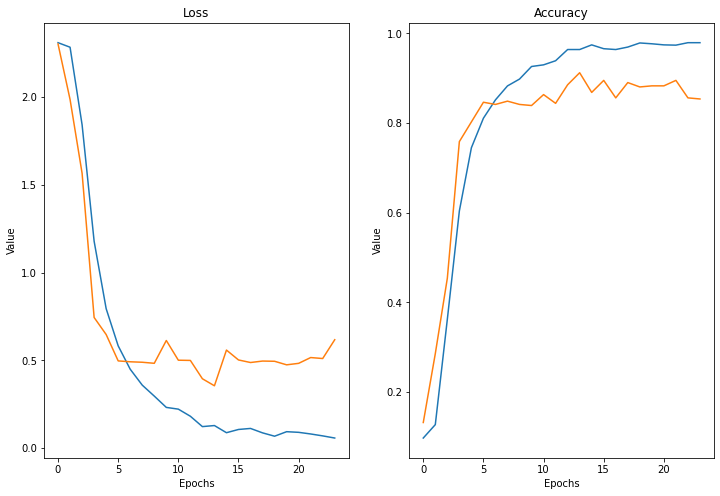

***************Trainig_my_model_1*****************
Epoch 1/200
1638/1638 [==============================] - 8s 5ms/step - loss: 2.3085 - accuracy: 0.1032 - val_loss: 2.3007 - val_accuracy: 0.1049
Epoch 2/200
1638/1638 [==============================] - 8s 5ms/step - loss: 2.2892 - accuracy: 0.1306 - val_loss: 2.1902 - val_accuracy: 0.2537
Epoch 3/200
1638/1638 [==============================] - 8s 5ms/step - loss: 1.8408 - accuracy: 0.3632 - val_loss: 1.3853 - val_accuracy: 0.5683
Epoch 4/200
1638/1638 [==============================] - 8s 5ms/step - loss: 1.0625 - accuracy: 0.6545 - val_loss: 0.9112 - val_accuracy: 0.6902
Epoch 5/200
1638/1638 [==============================] - 8s 5ms/step - loss: 0.7408 - accuracy: 0.7619 - val_loss: 0.6298 - val_accuracy: 0.8000
Epoch 6/200
1638/1638 [==============================] - 8s 5ms/step - loss: 0.5564 - accuracy: 0.8315 - val_loss: 0.4991 - val_accuracy: 0.8463
Epoch 7/200
1638/1638 [==============================] - 8s 5ms/step - loss: 0.

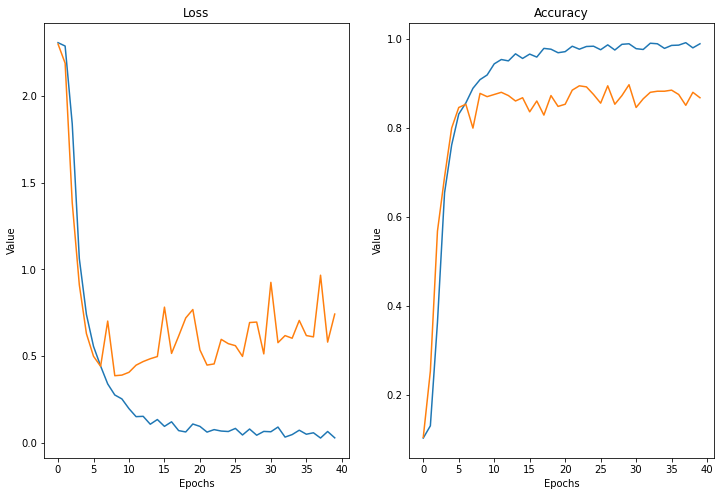

***************Trainig_my_model_2*****************
Epoch 1/200
1638/1638 [==============================] - 8s 5ms/step - loss: 2.3059 - accuracy: 0.1050 - val_loss: 2.3430 - val_accuracy: 0.1049
Epoch 2/200
1638/1638 [==============================] - 8s 5ms/step - loss: 2.2267 - accuracy: 0.1795 - val_loss: 1.9618 - val_accuracy: 0.3073
Epoch 3/200
1638/1638 [==============================] - 7s 5ms/step - loss: 1.6339 - accuracy: 0.4243 - val_loss: 1.0152 - val_accuracy: 0.6805
Epoch 4/200
1638/1638 [==============================] - 7s 5ms/step - loss: 0.9478 - accuracy: 0.6880 - val_loss: 0.6592 - val_accuracy: 0.7951
Epoch 5/200
1638/1638 [==============================] - 8s 5ms/step - loss: 0.6986 - accuracy: 0.7772 - val_loss: 0.5625 - val_accuracy: 0.8146
Epoch 6/200
1638/1638 [==============================] - 7s 5ms/step - loss: 0.5051 - accuracy: 0.8364 - val_loss: 0.4802 - val_accuracy: 0.8463
Epoch 7/200
1638/1638 [==============================] - 8s 5ms/step - loss: 0.

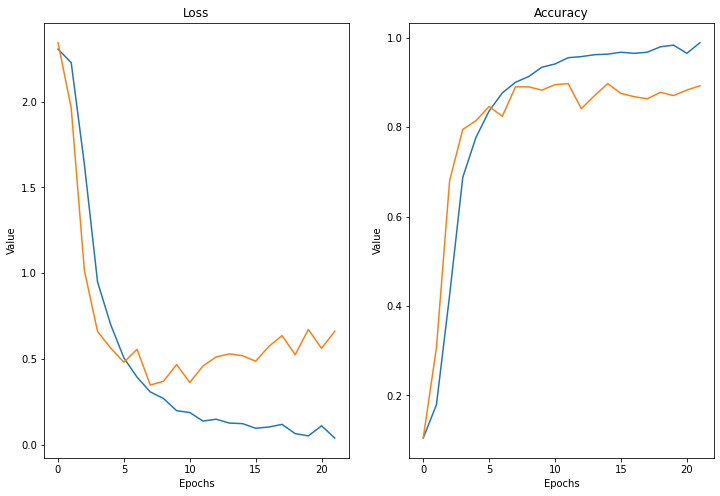

***************Trainig_my_model_3*****************
Epoch 1/200
1638/1638 [==============================] - 8s 5ms/step - loss: 2.3038 - accuracy: 0.1056 - val_loss: 2.2993 - val_accuracy: 0.1049
Epoch 2/200
1638/1638 [==============================] - 7s 5ms/step - loss: 2.2537 - accuracy: 0.1526 - val_loss: 1.9726 - val_accuracy: 0.3268
Epoch 3/200
1638/1638 [==============================] - 8s 5ms/step - loss: 1.6714 - accuracy: 0.4109 - val_loss: 1.0681 - val_accuracy: 0.6000
Epoch 4/200
1638/1638 [==============================] - 8s 5ms/step - loss: 0.9604 - accuracy: 0.6734 - val_loss: 0.6826 - val_accuracy: 0.7707
Epoch 5/200
1638/1638 [==============================] - 8s 5ms/step - loss: 0.6616 - accuracy: 0.7900 - val_loss: 0.5850 - val_accuracy: 0.8024
Epoch 6/200
1638/1638 [==============================] - 7s 5ms/step - loss: 0.5115 - accuracy: 0.8272 - val_loss: 0.4597 - val_accuracy: 0.8341
Epoch 7/200
1638/1638 [==============================] - 7s 5ms/step - loss: 0.

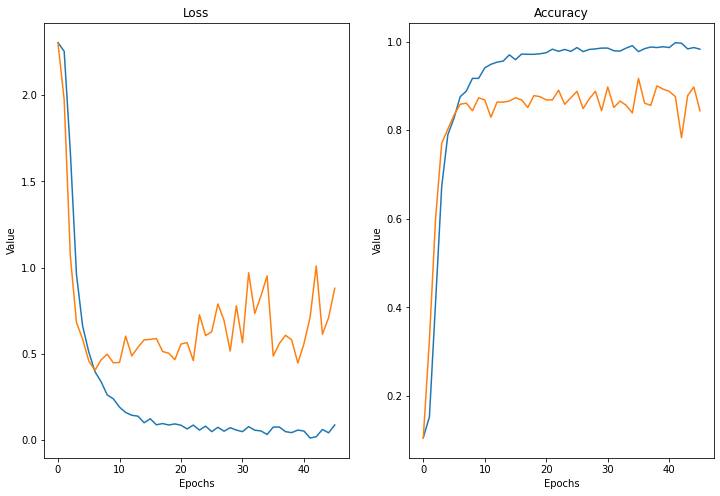

***************Trainig_my_model_4*****************
Epoch 1/200
1638/1638 [==============================] - 8s 5ms/step - loss: 2.3059 - accuracy: 0.1111 - val_loss: 2.2939 - val_accuracy: 0.0976
Epoch 2/200
1638/1638 [==============================] - 8s 5ms/step - loss: 2.1950 - accuracy: 0.1795 - val_loss: 1.7880 - val_accuracy: 0.3439
Epoch 3/200
1638/1638 [==============================] - 8s 5ms/step - loss: 1.5505 - accuracy: 0.4762 - val_loss: 0.9431 - val_accuracy: 0.6756
Epoch 4/200
1638/1638 [==============================] - 8s 5ms/step - loss: 0.9299 - accuracy: 0.6886 - val_loss: 0.7691 - val_accuracy: 0.7488
Epoch 5/200
1638/1638 [==============================] - 8s 5ms/step - loss: 0.6499 - accuracy: 0.7845 - val_loss: 0.5510 - val_accuracy: 0.8122
Epoch 6/200
1638/1638 [==============================] - 8s 5ms/step - loss: 0.5260 - accuracy: 0.8376 - val_loss: 0.4967 - val_accuracy: 0.8537
Epoch 7/200
1638/1638 [==============================] - 8s 5ms/step - loss: 0.

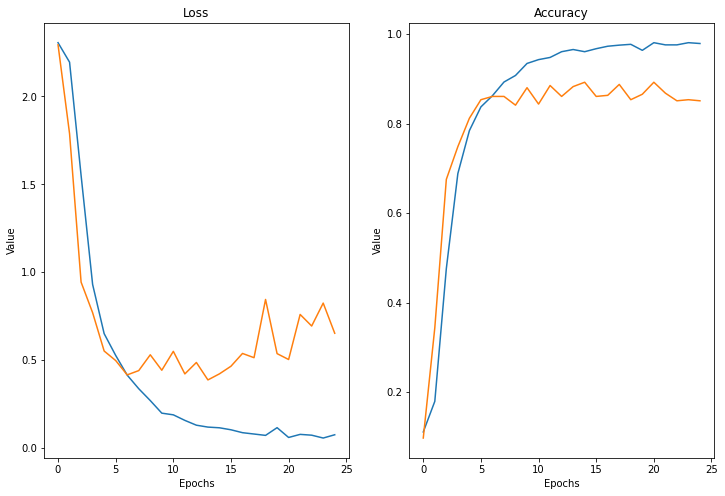

***************Trainig_my_model_5*****************
Epoch 1/200
1638/1638 [==============================] - 7s 4ms/step - loss: 2.3034 - accuracy: 0.1203 - val_loss: 2.3087 - val_accuracy: 0.0951
Epoch 2/200
1638/1638 [==============================] - 7s 4ms/step - loss: 2.2406 - accuracy: 0.1557 - val_loss: 1.9422 - val_accuracy: 0.2951
Epoch 3/200
1638/1638 [==============================] - 7s 4ms/step - loss: 1.6350 - accuracy: 0.4377 - val_loss: 1.0027 - val_accuracy: 0.6683
Epoch 4/200
1638/1638 [==============================] - 7s 4ms/step - loss: 0.9594 - accuracy: 0.6880 - val_loss: 0.6314 - val_accuracy: 0.7976
Epoch 5/200
1638/1638 [==============================] - 8s 5ms/step - loss: 0.6606 - accuracy: 0.7961 - val_loss: 0.5235 - val_accuracy: 0.8293
Epoch 6/200
1638/1638 [==============================] - 7s 4ms/step - loss: 0.5084 - accuracy: 0.8431 - val_loss: 0.4731 - val_accuracy: 0.8659
Epoch 7/200
1638/1638 [==============================] - 7s 4ms/step - loss: 0.

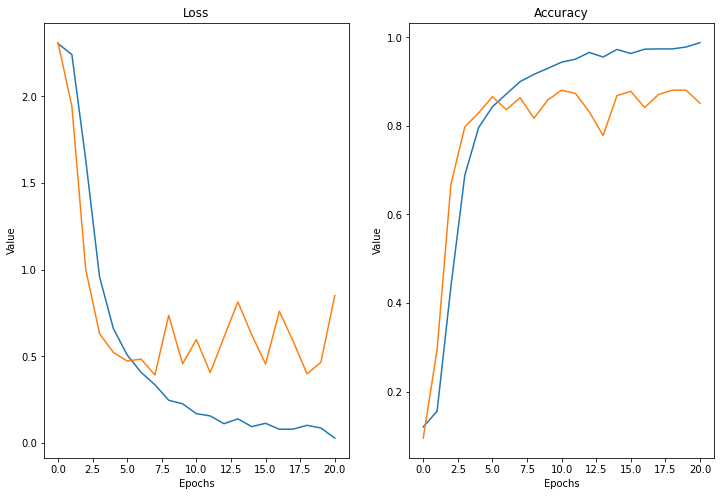

***************Trainig_my_model_6*****************
Epoch 1/200
1638/1638 [==============================] - 7s 5ms/step - loss: 2.3076 - accuracy: 0.1105 - val_loss: 2.2968 - val_accuracy: 0.1390
Epoch 2/200
1638/1638 [==============================] - 7s 4ms/step - loss: 2.2081 - accuracy: 0.1850 - val_loss: 1.8384 - val_accuracy: 0.3220
Epoch 3/200
1638/1638 [==============================] - 7s 4ms/step - loss: 1.5980 - accuracy: 0.4634 - val_loss: 0.9632 - val_accuracy: 0.6976
Epoch 4/200
1638/1638 [==============================] - 7s 4ms/step - loss: 0.9476 - accuracy: 0.6856 - val_loss: 0.5940 - val_accuracy: 0.8146
Epoch 5/200
1638/1638 [==============================] - 7s 4ms/step - loss: 0.6664 - accuracy: 0.7729 - val_loss: 0.5750 - val_accuracy: 0.8049
Epoch 6/200
1638/1638 [==============================] - 8s 5ms/step - loss: 0.5179 - accuracy: 0.8382 - val_loss: 0.4745 - val_accuracy: 0.8537
Epoch 7/200
1638/1638 [==============================] - 8s 5ms/step - loss: 0.

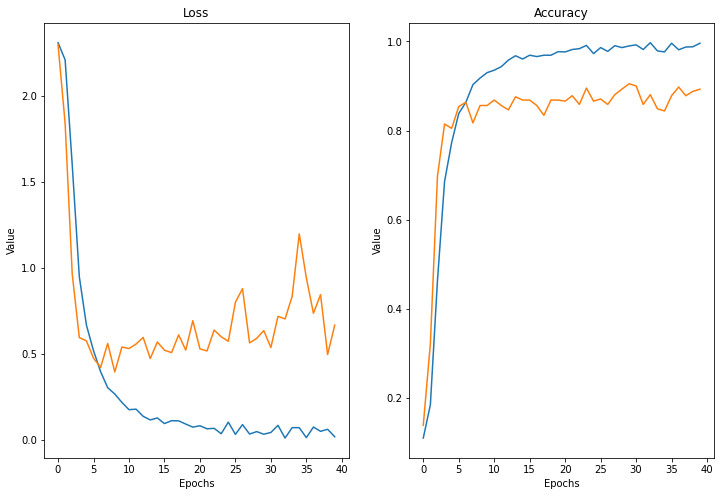

***************Trainig_my_model_7*****************
Epoch 1/200
1638/1638 [==============================] - 7s 5ms/step - loss: 2.3072 - accuracy: 0.1074 - val_loss: 2.3092 - val_accuracy: 0.1049
Epoch 2/200
1638/1638 [==============================] - 7s 4ms/step - loss: 2.2304 - accuracy: 0.1630 - val_loss: 1.8297 - val_accuracy: 0.3439
Epoch 3/200
1638/1638 [==============================] - 8s 5ms/step - loss: 1.5211 - accuracy: 0.4847 - val_loss: 0.9498 - val_accuracy: 0.7463
Epoch 4/200
1638/1638 [==============================] - 8s 5ms/step - loss: 0.8868 - accuracy: 0.7125 - val_loss: 0.6512 - val_accuracy: 0.7927
Epoch 5/200
1638/1638 [==============================] - 7s 4ms/step - loss: 0.6625 - accuracy: 0.7802 - val_loss: 0.5148 - val_accuracy: 0.8049
Epoch 6/200
1638/1638 [==============================] - 8s 5ms/step - loss: 0.5143 - accuracy: 0.8260 - val_loss: 0.4696 - val_accuracy: 0.8122
Epoch 7/200
1638/1638 [==============================] - 7s 4ms/step - loss: 0.

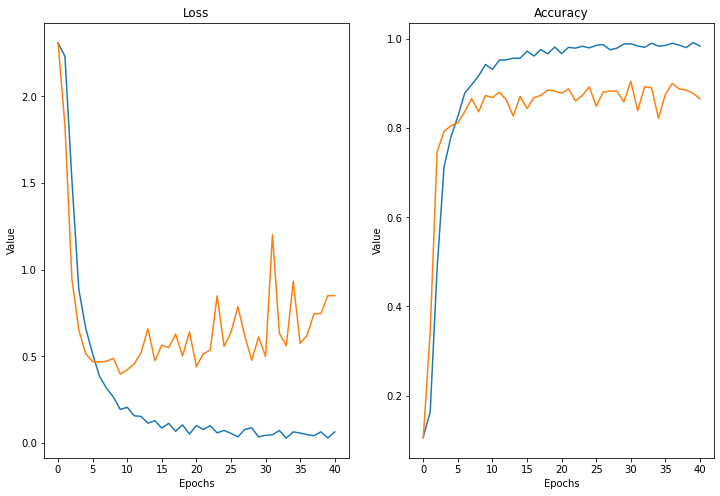

***************Trainig_my_model_8*****************
Epoch 1/200
1638/1638 [==============================] - 8s 5ms/step - loss: 2.3059 - accuracy: 0.1117 - val_loss: 2.2888 - val_accuracy: 0.1049
Epoch 2/200
1638/1638 [==============================] - 8s 5ms/step - loss: 2.1619 - accuracy: 0.2137 - val_loss: 1.7734 - val_accuracy: 0.3707
Epoch 3/200
1638/1638 [==============================] - 8s 5ms/step - loss: 1.4699 - accuracy: 0.4994 - val_loss: 0.8677 - val_accuracy: 0.7195
Epoch 4/200
1638/1638 [==============================] - 8s 5ms/step - loss: 0.9292 - accuracy: 0.7057 - val_loss: 0.7486 - val_accuracy: 0.7561
Epoch 5/200
1638/1638 [==============================] - 8s 5ms/step - loss: 0.6386 - accuracy: 0.7967 - val_loss: 0.6597 - val_accuracy: 0.7951
Epoch 6/200
1638/1638 [==============================] - 8s 5ms/step - loss: 0.5113 - accuracy: 0.8315 - val_loss: 0.5097 - val_accuracy: 0.8293
Epoch 7/200
1638/1638 [==============================] - 8s 5ms/step - loss: 0.

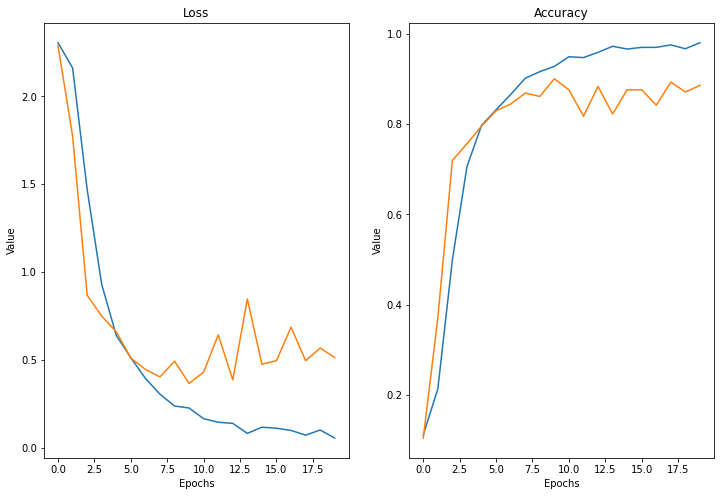

***************Trainig_my_model_9*****************
Epoch 1/200
1638/1638 [==============================] - 8s 5ms/step - loss: 2.3053 - accuracy: 0.1117 - val_loss: 2.3060 - val_accuracy: 0.0951
Epoch 2/200
1638/1638 [==============================] - 8s 5ms/step - loss: 2.2386 - accuracy: 0.1526 - val_loss: 1.9274 - val_accuracy: 0.3415
Epoch 3/200
1638/1638 [==============================] - 8s 5ms/step - loss: 1.6488 - accuracy: 0.4347 - val_loss: 1.0144 - val_accuracy: 0.6610
Epoch 4/200
1638/1638 [==============================] - 8s 5ms/step - loss: 0.9994 - accuracy: 0.6740 - val_loss: 0.6839 - val_accuracy: 0.7756
Epoch 5/200
1638/1638 [==============================] - 8s 5ms/step - loss: 0.7204 - accuracy: 0.7607 - val_loss: 0.5525 - val_accuracy: 0.8171
Epoch 6/200
1638/1638 [==============================] - 8s 5ms/step - loss: 0.5524 - accuracy: 0.8266 - val_loss: 0.6012 - val_accuracy: 0.7854
Epoch 7/200
1638/1638 [==============================] - 8s 5ms/step - loss: 0.

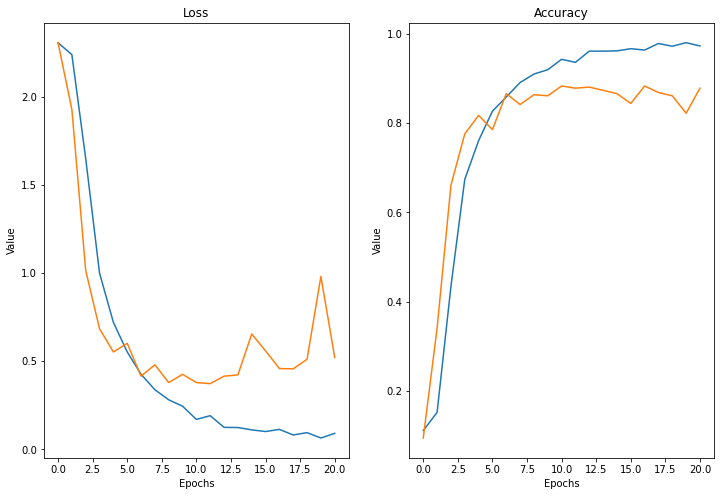

In [94]:
### Training
epochs = 200
batch_size = 1
validation_split = 0.2

for i in range(len(model_list)):
    print("***************Trainig_my_model_{}*****************".format(i))
    epoch, hist = train_model_v1(model_list[i], X_train, y_train, X_val, y_val, epochs, batch_size) 

    # Plot a graph of the metric vs. epochs.
    list_of_metrics_to_plot = ['loss','val_loss','accuracy','val_accuracy']
    plot_curve(epoch, hist, list_of_metrics_to_plot)

In [95]:
result_list = []

for i in range(len(model_list)):
    print("************************Evaluating_my_model_{}************************".format(i))
    result = model_list[i].evaluate(X_val, y_val)
    result_list.append(result)

************************Evaluating_my_model_0************************
13/13 [==============================] - 7s 513ms/step - loss: 0.3552 - accuracy: 0.9122
************************Evaluating_my_model_1************************
13/13 [==============================] - 0s 11ms/step - loss: 0.5129 - accuracy: 0.8976
************************Evaluating_my_model_2************************
13/13 [==============================] - 0s 7ms/step - loss: 0.4581 - accuracy: 0.8976
************************Evaluating_my_model_3************************
13/13 [==============================] - 0s 8ms/step - loss: 0.4875 - accuracy: 0.9171
************************Evaluating_my_model_4************************
13/13 [==============================] - 0s 7ms/step - loss: 0.4211 - accuracy: 0.8927
************************Evaluating_my_model_5************************
13/13 [==============================] - 0s 7ms/step - loss: 0.5972 - accuracy: 0.8805
************************Evaluating_my_model_6**********

In [96]:
pred_list = []

for i in range(len(model_list)):
    print("************************Predicting_my_model_{}************************".format(i))
    pred = model_list[i].predict(X_test)
    pred_list.append(pred)

************************Predicting_my_model_0************************
************************Predicting_my_model_1************************
************************Predicting_my_model_2************************
************************Predicting_my_model_3************************
************************Predicting_my_model_4************************
************************Predicting_my_model_5************************
************************Predicting_my_model_6************************
************************Predicting_my_model_7************************
************************Predicting_my_model_8************************
************************Predicting_my_model_9************************


In [97]:
pred_df = pd.DataFrame(test["id"])
final_pred = np.array([0] * 204800).reshape(20480, 10)

for i in range(len(model_list)):
    pred_df['pred{}'.format(i)] = np.argmax(pred_list[i], axis = 1)
    final_pred = final_pred + pred_list[i]

pred_df['final_pred'] = np.argmax(final_pred, axis = 1)

In [98]:
pred_df

,id,pred0,pred1,pred2,pred3,pred4,pred5,pred6,pred7,pred8,pred9,final_pred
0,2049,2,6,6,6,6,6,6,6,6,6,6
1,2050,8,9,9,9,9,8,9,9,9,9,9
2,2051,8,8,8,2,8,2,3,8,8,8,8
3,2052,0,0,0,0,0,0,0,0,0,0,0
4,2053,3,3,3,3,3,3,3,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...
20475,22524,4,4,4,4,4,4,4,4,4,4,4
20476,22525,1,1,1,1,1,1,1,1,1,1,1
20477,22526,6,6,6,6,6,6,6,6,6,6,6
20478,22527,3,5,3,3,3,3,3,1,3,3,3


In [99]:
# 파일 제출
submission = pred_df[['id', 'final_pred']].rename(columns = {'final_pred' : 'digit'})
submission.to_csv("km_MNIST31.csv", index = False)
submission

,id,digit
0,2049,6
1,2050,9
2,2051,8
3,2052,0
4,2053,3
...,...,...
20475,22524,4
20476,22525,1
20477,22526,6
20478,22527,3


- train_set으로 학습이 끝난 후 val_set으로 다시 학습시켜보았습니다.

In [18]:
re_model_list = []

for i in range(len(model_list)):
    print("************************Loading_my_model_{}************************".format(i))
    my_model = tf.keras.models.load_model('D:/data/CNN 모델/my_model16/model{}'.format(i))
    my_model.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.00001),
                 loss = 'sparse_categorical_crossentropy',
                 metrics = ['accuracy'])
    
    print("************************Re-training_my_model_{}************************".format(i))
    my_model.fit(X_val, y_val, epochs = 5, batch_size = 1)
    
    re_model_list.append(my_model)

************************Loading_my_model_0************************
************************Re-training_my_model_0************************
Train on 410 samples
Epoch 1/5
410/410 [==============================] - 28s 68ms/sample - loss: 0.5250 - accuracy: 0.8805
Epoch 2/5
410/410 [==============================] - 27s 67ms/sample - loss: 0.4427 - accuracy: 0.9024
Epoch 3/5
410/410 [==============================] - 27s 67ms/sample - loss: 0.2551 - accuracy: 0.9220
Epoch 4/5
410/410 [==============================] - 30s 73ms/sample - loss: 0.1889 - accuracy: 0.9341
Epoch 5/5
410/410 [==============================] - 32s 78ms/sample - loss: 0.1390 - accuracy: 0.9488 - l
************************Loading_my_model_1************************
************************Re-training_my_model_1************************
Train on 410 samples
Epoch 1/5
410/410 [==============================] - 32s 79ms/sample - loss: 0.5096 - accuracy: 0.8780
Epoch 2/5
410/410 [==============================] - 30s 73m

In [19]:
# test_set 예측하기

re_pred_list = []

for i in range(len(model_list)):
    print("************************Predicting_my_re_model_{}************************".format(i))
    pred = re_model_list[i].predict(X_test)
    re_pred_list.append(pred)

************************Predicting_my_re_model_0************************
************************Predicting_my_re_model_1************************
************************Predicting_my_re_model_2************************
************************Predicting_my_re_model_3************************
************************Predicting_my_re_model_4************************
************************Predicting_my_re_model_5************************
************************Predicting_my_re_model_6************************
************************Predicting_my_re_model_7************************
************************Predicting_my_re_model_8************************
************************Predicting_my_re_model_9************************


In [21]:
re_pred_df = pd.DataFrame(test["id"])
re_final_pred = np.array([0] * 204800).reshape(20480, 10)

for i in range(len(model_list)):
    re_pred_df['pred{}'.format(i)] = np.argmax(re_pred_list[i], axis = 1)
    re_final_pred = re_final_pred + re_pred_list[i]

re_pred_df['final_pred'] = np.argmax(re_final_pred, axis = 1)

In [22]:
re_pred_df

,id,pred0,pred1,pred2,pred3,pred4,pred5,pred6,pred7,pred8,pred9,final_pred
0,2049,6,6,6,6,6,6,6,6,6,6,6
1,2050,8,9,9,9,8,9,9,9,9,9,9
2,2051,8,8,8,8,8,8,8,8,8,8,8
3,2052,0,0,0,0,0,0,0,0,0,0,0
4,2053,3,3,3,3,3,3,3,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...
20475,22524,4,4,4,4,4,4,4,4,4,4,4
20476,22525,1,1,1,1,1,1,1,1,1,1,1
20477,22526,6,6,6,6,6,6,6,6,6,6,6
20478,22527,8,3,3,8,3,3,3,3,3,3,3


In [23]:
# 파일 제출
submission = re_pred_df[['id', 'final_pred']].rename(columns = {'final_pred' : 'digit'})
submission.to_csv("transformed_MNIST31.csv", index = False)
submission

,id,digit
0,2049,6
1,2050,9
2,2051,8
3,2052,0
4,2053,3
...,...,...
20475,22524,4
20476,22525,1
20477,22526,6
20478,22527,3
